# Basic Text Classification with Naive Bayes
Based on the predictiors that we have observed, what is the probability that the outcome is class Ci?

To estimate the individual probabilities $P(Data)$ and/or $P(Class)$ for priors:
- Assumption of normality can be made for continuous predictors using the sample mean and variance from the training set,
- For categorical predictors, the probability distribution can be determined using the frequencies from observed training data set.
***
In the mini-project, you'll learn the basics of text analysis using a subset of movie reviews from the rotten tomatoes database. You'll also use a fundamental technique in Bayesian inference, called Naive Bayes. This mini-project is based on [Lab 10 of Harvard's CS109](https://github.com/cs109/2015lab10) class.  Please free to go to the original lab for additional exercises and solutions.

In [1]:
from six.moves import range
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import scipy as sp
import numpy as np
%matplotlib inline

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

# Table of Contents

* [Rotten Tomatoes Dataset](#Rotten-Tomatoes-Dataset)
    * [Explore](#Explore)
* [The Vector Space Model and a Search Engine](#The-Vector-Space-Model-and-a-Search-Engine)
    * [In Code](#In-Code)
* [Naive Bayes](#Naive-Bayes)
    * [Multinomial Naive Bayes and Other Likelihood Functions](#Multinomial-Naive-Bayes-and-Other-Likelihood-Functions)
    * [Picking Hyperparameters for Naive Bayes and Text Maintenance](#Picking-Hyperparameters-for-Naive-Bayes-and-Text-Maintenance)
* [Interpretation](#Interpretation)


## Rotten Tomatoes Dataset

### What is the Tomatometer®?

- When at least 60% of reviews for a movie or TV show are positive, a red tomato is displayed to indicate its Fresh status.
- When less than 60% of reviews for a movie or TV show are positive, a green splat is displayed to indicate its Rotten status.

In [2]:
critics = pd.read_csv('./critics.csv')
# let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


### Explore

In [3]:
n_reviews = critics.shape[0]
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size


print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


In [4]:
# Make a copy of the dataframe to preserve the original
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
grp

Text(0,0.5,'Number of Critics')

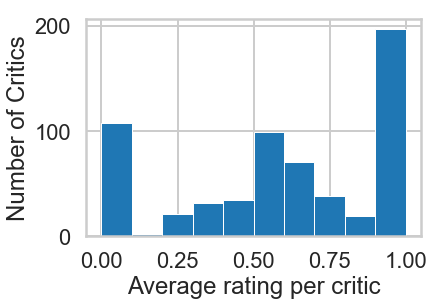

In [5]:
means2 = grp.mean()['fresh']
means2.hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average rating per critic")
plt.ylabel("Number of Critics")

In [6]:
# Get only critics who have more than 100 reviews
counts = grp.critic.count()  # number of reviews by each critic
counts_above = counts[counts.sort_values(
    axis=0, ascending=False) > 100].sort_values(axis=0, ascending=False)
print('{} critic has more than 100 reviews.'.format(counts_above.size))

37 critic has more than 100 reviews.


Text(0,0.5,'Number of Critics')

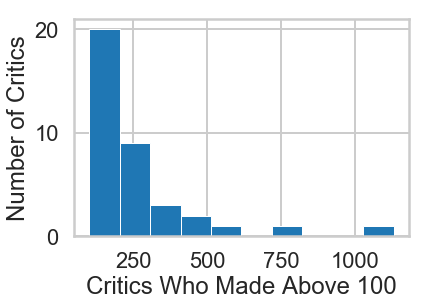

In [7]:
counts_above.hist(bins=10, edgecolor='w', lw=1)  # linewidth=1
plt.xlabel("Critics Who Made Above 100")
plt.ylabel("Number of Critics")
#plt.yticks([0, 2, 4, 6, 8, 10]);

([<matplotlib.axis.YTick at 0x10fd781d0>,
 <a list of 7 Text yticklabel objects>)

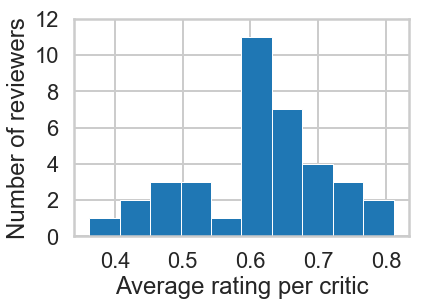

In [8]:
# Now look at distribution of the mean number of reviews within above 100 group
mean_above = grp.fresh.mean()[grp.critic.count() > 100]
mean_above.hist(bins=10, edgecolor='w', lw=1)

plt.xlabel("Average rating per critic")
plt.ylabel("Number of reviewers")
plt.yticks([0, 2, 4, 6, 8, 10, 12])

<div class="span5 alert alert-info">
<h3>Exercise Set I</h3>
<br/>
<b>Exercise:</b> Look at the histogram above. Tell a story about the average ratings per critic. What shape does the distribution look like? What is interesting about the distribution? What might explain these interesting things?
</div>

> We see two distinct groups in reviewers. The majority of the reviewers (critics) gives positive reviews in 60 % or more of their reviews.
>
> The minority group tend to have normal distribution around 0.5. That incidates half their reviews are positive (fresh) and half are negative (rotten).
>
>Overall, this distribution shows bimodal behavior.
>
>

## The Vector Space Model and a Search Engine

All the diagrams here are snipped from [*Introduction to Information Retrieval* by Manning et. al.]( http://nlp.stanford.edu/IR-book/) which is a great resource on text processing. For additional information on text mining and natural language processing, see [*Foundations of Statistical Natural Language Processing* by Manning and Schutze](http://nlp.stanford.edu/fsnlp/).

Also check out Python packages [`nltk`](http://www.nltk.org/), [`spaCy`](https://spacy.io/), [`pattern`](http://www.clips.ua.ac.be/pattern), and their associated resources. Also see [`word2vec`](https://en.wikipedia.org/wiki/Word2vec).

Let us define the vector derived from document $d$ by $\bar V(d)$. What does this mean? Each document is treated as a vector containing information about the words contained in it. Each vector has the same length and each entry "slot" in the vector contains some kind of data about the words that appear in the document such as presence/absence (1/0), count (an integer) or some other statistic. Each vector has the same length because each document shared the same vocabulary across the full collection of documents -- this collection is called a *corpus*.

To define the vocabulary, we take a union of all words we have seen in all documents. We then just associate an array index with them. So "hello" may be at index 5 and "world" at index 99.

Suppose we have the following corpus:

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree. The grapes seemed ready to burst with juice, and the Fox's mouth watered as he gazed longingly at them.`

Suppose we treat each sentence as a document $d$. The vocabulary (often called the *lexicon*) is the following:

$V = \left\{\right.$ `a, along, and, as, at, beautiful, branches, bunch, burst, day, fox, fox's, from, gazed, grapes, hanging, he, juice, longingly, mouth, of, one, ready, ripe, seemed, spied, the, them, to, trained, tree, vine, watered, with`$\left.\right\}$

Then the document

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree`

may be represented as the following sparse vector of word counts:

$$\bar V(d) = \left( 4,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,0,0,0,2,1,0,1,0,0,1,0,0,1,1,1,0,0 \right)$$

or more succinctly as

`[(0, 4), (1, 1), (5, 1), (6, 1), (7, 1), (9, 1), (10, 1), (12, 1), (14, 1), (15, 1), (20, 2), (21, 1), (23, 1),`
`(26, 1), (29,1), (30, 1), (31, 1)]`

along with a dictionary ( representing the corpus )

``
{
    0: a, 1: along, 5: beautiful, 6: branches, 7: bunch, 9: day, 10: fox, 12: from, 14: grapes, 15: hanging, 19: mouth, 20: of, 21: one, 23: ripe, 24: seemed, 25: spied, 26: the, 29:trained, 30: tree, 31: vine, 
}
``

Then, a set of documents becomes, in the usual `sklearn` style, a sparse matrix with rows being sparse arrays representing documents and columns representing the features/words in the vocabulary.

Notice that this representation loses the relative ordering of the terms in the document. That is "cat ate rat" and "rat ate cat" are the same. Thus, this representation is also known as the Bag-Of-Words representation. 

> The produced text follows only the frequency rules of the language and nothing more.

Here is another example, from the book quoted above, although the matrix is transposed here so that documents are columns:

![novel terms](terms.png)

Such a matrix is also catted a Term-Document Matrix. Here, the terms being indexed could be stemmed before indexing; for instance, `jealous` and `jealousy` after stemming are the same feature. One could also make use of other "Natural Language Processing" transformations in constructing the vocabulary. We could use Lemmatization, which reduces words to lemmas: work, working, worked would all reduce to work. We could remove "stopwords" from our vocabulary, such as common words like "the". We could look for particular parts of speech, such as adjectives. This is often done in Sentiment Analysis. And so on. It all depends on our application.

From the book:
>The standard way of quantifying the similarity between two documents $d_1$ and $d_2$  is to compute the cosine similarity of their vector representations $\bar V(d_1)$ and $\bar V(d_2)$:

$$S_{12} = \frac{\bar V(d_1) \cdot \bar V(d_2)}{|\bar V(d_1)| \times |\bar V(d_2)|}$$

![Vector Space Model](vsm.png)

>> Student: This jump here seems not reasonable. We talked about measuring the similarity and now we are looking at search/query construction ???

>There is a far more compelling reason to represent documents as vectors: we can also view a query as a vector. Consider the query q = jealous gossip. This query turns into the unit vector $\bar V(q)$ = (0, 0.707, 0.707) on the three coordinates below. 

![novel terms](terms2.png)

>The key idea now: to assign to each document d a score equal to the dot product:

$$\bar V(q) \cdot \bar V(d)$$

Then we can use this simple Vector Model as a Search engine.

### In Code

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory,
# but it's easier in this assignment to
# convert back to a "normal" numpy array
x_array = x.toarray()

print("")
print("Transformed text vector is \n{}".format(x_array))

# `get_feature_names` tracks which word is associated with each
# column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't
# preserve information about the *order* of words,
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
['hop', 'off', 'on', 'pop']


In [10]:
def make_xy(critics, vectorizer=None):
    # Your code here
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics['quote'])
    # Convert X to Compressed Sparse Column format
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y


X, y = make_xy(critics)

> Sparse Matrices and their reps [here](https://rushter.com/blog/scipy-sparse-matrices/)

## Naive Bayes

From Bayes' Theorem, we have that

$$P(c \vert f) = \frac{P(f \vert c)*P(c)}{P(f)}$$
where ${P(f) = P(f \vert c)*P(c) + P(f \vert c^\complement)*P(c^\complement)}$
and $c$ represents a *class* or category, and $f$ represents a feature vector, such as $\bar V(d)$ as above. **We are computing the probability that a document (or whatever we are classifying) belongs to category *c* given the features in the document.** $P(f)$ is really just a normalization constant, so the literature usually writes Bayes' Theorem in context of Naive Bayes as

$$P(c \vert f) \propto P(f \vert c) P(c) $$  where $$ P(f \vert c) = \frac{P(f \cap c)}{P(c)}$$

$P(c)$ is called the *prior* and is simply the probability of seeing class $c$. But what is $P(f \vert c)$? This is the probability that we see feature set $f$ given that this document is actually in class $c$. This is called the *likelihood* and comes from the data. One of the major assumptions of the Naive Bayes model is that the features are *conditionally independent* given the class. While the presence of a particular discriminative word may uniquely identify the document as being part of class $c$ and thus violate general feature independence, conditional independence means that the presence of that term is independent of all the other words that appear *within that class*. This is a very important distinction. Recall that if two events are independent, then:

$$P(A \cap B) = P(A) \cdot P(B)$$

Thus, conditional independence implies

$$P(f \vert c)  = \prod_i P(f_i | c) $$

where $f_i$ is an individual feature (a word in this example).

To make a classification, we then choose the class $c$ such that $P(c \vert f)$ is maximal.

There is a small caveat when computing these probabilities. For [floating point underflow](http://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html) we change the product into a sum by going into log space. This is called the LogSumExp trick. So:

$$\log P(f \vert c)  = \sum_i \log P(f_i \vert c) $$

There is another caveat. What if we see a term that didn't exist in the training data? This means that $P(f_i \vert c) = 0$ for that term, and thus $P(f \vert c)  = \prod_i P(f_i | c) = 0$, which doesn't help us at all. Instead of using zeros, we add a small negligible value called $\alpha$ to each count. This is called Laplace Smoothing.

$$P(f_i \vert c) = \frac{N_{ic}+\alpha}{N_c + \alpha N_i}$$

where $N_{ic}$ is the number of times feature $i$ was seen in class $c$, $N_c$ is the number of times class $c$ was seen and $N_i$ is the number of times feature $i$ was seen globally. $\alpha$ is sometimes called a regularization parameter.

### Multinomial Naive Bayes and Other Likelihood Functions

Since we are modeling word counts, we are using variation of Naive Bayes called Multinomial Naive Bayes. This is because the likelihood function actually takes the form of the multinomial distribution.

$$P(f \vert c) = \frac{\left( \sum_i f_i \right)!}{\prod_i f_i!} \prod_{f_i} P(f_i \vert c)^{f_i} \propto \prod_{i} P(f_i \vert c)$$

where the nasty term out front is absorbed as a normalization constant such that probabilities sum to 1.

There are many other variations of Naive Bayes, all which depend on what type of value $f_i$ takes. If $f_i$ is continuous, we may be able to use *Gaussian Naive Bayes*. First compute the mean and variance for each class $c$. Then the likelihood, $P(f \vert c)$ is given as follows

$$P(f_i = v \vert c) = \frac{1}{\sqrt{2\pi \sigma^2_c}} e^{- \frac{\left( v - \mu_c \right)^2}{2 \sigma^2_c}}$$

<div class="span5 alert alert-info">
<h3>Exercise Set II</h3>

<p><b>Exercise:</b> Implement a simple Naive Bayes classifier:</p>

<ol>
<li> split the data set into a training and test set
<li> Use `scikit-learn`'s `MultinomialNB()` classifier with default parameters.
<li> train the classifier over the training set and test on the test set
<li> print the accuracy scores for both the training and the test sets
</ol>

What do you notice? Is this a good classifier? If not, why not?
</div>

In [11]:
X

<15561x22417 sparse matrix of type '<class 'numpy.int64'>'
	with 272265 stored elements in Compressed Sparse Column format>

In [12]:
y

array([1, 1, 1, ..., 1, 1, 1])

In [13]:
# Split
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.3)

In [14]:
# Fit
multi_nb = MultinomialNB()
multi_nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [15]:
# Returns the mean accuracy on the given test data and labels.
training_set_accuracy = multi_nb.score(X_train, y_train)
print('Accuracy on Training Set: {:4f}'.format(training_set_accuracy))

test_set_accuracy = multi_nb.score(X_test, y_test)
print('Accuracy on Test Set: {:.4f}'.format(test_set_accuracy))

Accuracy on Training Set: 0.923338
Accuracy on Test Set: 0.7783


> The accuracy of test set indicates that the algorithm could not do a good job when generalizing the model to hold out data, compared to result from the training set. Clearly this is an overfit classifier.

### Picking Hyperparameters for Naive Bayes and Text Maintenance

We need to know what value to use for $\alpha$, and we also need to know which words to include in the vocabulary. As mentioned earlier, some words are obvious stopwords. Other words appear so infrequently that they serve as noise, and other words in addition to stopwords appear so frequently that they may also serve as noise.

First, let's find an appropriate value for `min_df` for the `CountVectorizer`. `min_df` can be either an integer or a float/decimal. If it is an integer, `min_df` represents the minimum number of documents a word must appear in for it to be included in the vocabulary. If it is a float, it represents the minimum *percentage* of documents a word must appear in to be included in the vocabulary. From the documentation:

>min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

<div class="span5 alert alert-info">
<h3>Exercise Set III</h3>

<p><b>Exercise:</b> Construct the cumulative distribution of document frequencies (df). The $x$-axis is a document count $x_i$ and the $y$-axis is the percentage of words that appear less than $x_i$ times. For example, at $x=5$, plot a point representing the percentage or number of words that appear in 5 or fewer documents.</p>

<p><b>Exercise:</b> Look for the point at which the curve begins climbing steeply. This may be a good value for `min_df`. If we were interested in also picking `max_df`, we would likely pick the value where the curve starts to plateau. What value did you choose?</p>
</div>

> We do have at least a word in each document since column totals are not zero at all. Let's find the
word frequency in each document. What we want to get is that if we know how often a word is used or not we can eliminate some words that are used too often and that are used not often.

####  Approach 1

In [16]:
# Number of Documents (Lines in Quote)
critics['quote'].shape

(15561,)

In [17]:
critics['quote'].iloc[0]

'So ingenious in concept, design and execution that you could watch it on a postage stamp-sized screen and still be engulfed by its charm.'

In [18]:
# Isolate the reviews in the dataframe
df_words = critics["quote"]

# Put the reviews into a list 
documents = [document for document in df_words]
text_lines = []
for document in documents:
    text_lines.append(document)

In [19]:
documents[0]

'So ingenious in concept, design and execution that you could watch it on a postage stamp-sized screen and still be engulfed by its charm.'

In [20]:
text_lines[0]

'So ingenious in concept, design and execution that you could watch it on a postage stamp-sized screen and still be engulfed by its charm.'

In [21]:
# Create a dictionary and tally the occurrence of each words
occurrences = {}
for text in text_lines:
    found_words = set([])
    for word in text.split():
        # Check if a word in the set
        if word in found_words:
            continue # else go up to start of the second loop
        occurrences[word] = 1 + occurrences.get(word,0)
        found_words.add(word)

In [22]:
occurrences

{'interleaving': 1,
 'film-noir': 1,
 'apsiration;': 1,
 'buoyed': 2,
 'eye-teasers.': 1,
 'paranoid,': 2,
 'modest': 29,
 'Mead': 1,
 'Bet': 1,
 'gratuitous': 7,
 'Ronald': 1,
 'buzzes': 1,
 'wants': 48,
 'audience,': 12,
 'surfing.': 1,
 'desensitizing': 1,
 'telepathically,': 1,
 'veracity': 1,
 'stakes': 2,
 'Flawed,': 1,
 'token': 2,
 "film'": 1,
 'inability': 6,
 'Harrelson': 2,
 'relations.': 2,
 'pouty': 1,
 'excel': 2,
 'slumming': 2,
 'Griffith,': 2,
 'luscious': 4,
 'butterfly': 1,
 'own;': 1,
 'Encino': 1,
 'evangelical': 1,
 'drawn-out,': 1,
 'trusting': 1,
 'bright': 32,
 'reviews': 1,
 'Volkswagen.': 1,
 'detail:': 2,
 'yearn': 1,
 'rancid': 3,
 'restraint.': 3,
 'response': 7,
 'turtleneck': 1,
 'comfort.': 2,
 'heavyweight': 2,
 'Breathing': 1,
 'DOA.': 1,
 'abyss': 2,
 'performance...guarantees': 1,
 'sensationalizes': 1,
 'politics': 13,
 'types.': 2,
 'chuckled': 1,
 'quasidocumentary,': 1,
 'glossy,': 2,
 'Mama,': 1,
 'elapsed': 1,
 'filmmakers:': 1,
 'cliche-drive

In [23]:
# Sort dictionary by value
usage_freq = sorted(occurrences, key=occurrences.__getitem__, reverse=True)

In [24]:
usage_freq

['the',
 'and',
 'of',
 'a',
 'is',
 'to',
 'in',
 'that',
 'The',
 'it',
 'with',
 'but',
 'as',
 'for',
 'its',
 'A',
 'film',
 'this',
 'movie',
 'an',
 'has',
 'on',
 'be',
 'by',
 'are',
 'not',
 'than',
 'more',
 'his',
 'from',
 'about',
 'at',
 "it's",
 'one',
 'all',
 'have',
 "It's",
 '--',
 'you',
 'most',
 'like',
 'so',
 'This',
 'or',
 'into',
 'who',
 'It',
 'much',
 'up',
 'good',
 'can',
 'even',
 'just',
 'which',
 'he',
 'out',
 'what',
 'I',
 'story',
 'best',
 'if',
 'make',
 'their',
 'some',
 'only',
 'no',
 'too',
 'may',
 'been',
 'will',
 'was',
 'makes',
 'comedy',
 'never',
 'when',
 'very',
 'little',
 'first',
 'An',
 "doesn't",
 'any',
 'they',
 'enough',
 'characters',
 'As',
 'movies',
 'way',
 'great',
 'director',
 'But',
 'time',
 'does',
 'If',
 'made',
 'action',
 'still',
 'it.',
 'us',
 'without',
 'many',
 'In',
 'would',
 'kind',
 'seems',
 'something',
 "isn't",
 'two',
 'picture',
 'ever',
 'how',
 "that's",
 'funny',
 'also',
 'new',
 'such'

In [25]:
sorted_by_value = sorted(occurrences.items(), key=lambda kv: kv[1], reverse=True)

In [26]:
sorted_by_value

[('the', 8332),
 ('and', 7331),
 ('of', 7076),
 ('a', 6588),
 ('is', 4976),
 ('to', 4858),
 ('in', 3388),
 ('that', 2947),
 ('The', 2748),
 ('it', 2245),
 ('with', 2226),
 ('but', 2053),
 ('as', 1804),
 ('for', 1767),
 ('its', 1598),
 ('A', 1567),
 ('film', 1567),
 ('this', 1554),
 ('movie', 1506),
 ('an', 1420),
 ('has', 1212),
 ('on', 1210),
 ('be', 1205),
 ('by', 1129),
 ('are', 1036),
 ('not', 1008),
 ('than', 985),
 ('more', 954),
 ('his', 928),
 ('from', 896),
 ('about', 884),
 ('at', 873),
 ("it's", 837),
 ('one', 836),
 ('all', 825),
 ('have', 824),
 ("It's", 817),
 ('--', 813),
 ('you', 781),
 ('most', 745),
 ('like', 706),
 ('so', 702),
 ('This', 680),
 ('or', 638),
 ('into', 618),
 ('who', 573),
 ('It', 566),
 ('much', 523),
 ('up', 489),
 ('good', 466),
 ('can', 464),
 ('even', 455),
 ('just', 455),
 ('which', 449),
 ('he', 447),
 ('out', 439),
 ('what', 435),
 ('I', 429),
 ('story', 420),
 ('best', 411),
 ('if', 408),
 ('make', 405),
 ('their', 400),
 ('some', 398),
 ('onl

In [27]:
# First 20
usage_freq[:20]

['the',
 'and',
 'of',
 'a',
 'is',
 'to',
 'in',
 'that',
 'The',
 'it',
 'with',
 'but',
 'as',
 'for',
 'its',
 'A',
 'film',
 'this',
 'movie',
 'an']

In [28]:
# Last 20
usage_freq[-20:]

['unself-conscious,',
 "Zhang's",
 'limiting,',
 'Runner"',
 'Whitfield)',
 'finer',
 '-family',
 'risked',
 'pretty.',
 'firefly',
 'sleep',
 'engenders',
 'Dick-inspired',
 'outlandishly',
 'juiced-up',
 'Guffman',
 'Jacobean-style',
 'rut.',
 "forerunner's",
 'blaze']

In [29]:
import operator

sorted_occurrences = sorted(occurrences.items(), key=operator.itemgetter(1), reverse=True)
sorted_occurrences[-20:] 



[('unself-conscious,', 1),
 ("Zhang's", 1),
 ('limiting,', 1),
 ('Runner"', 1),
 ('Whitfield)', 1),
 ('finer', 1),
 ('-family', 1),
 ('risked', 1),
 ('pretty.', 1),
 ('firefly', 1),
 ('sleep', 1),
 ('engenders', 1),
 ('Dick-inspired', 1),
 ('outlandishly', 1),
 ('juiced-up', 1),
 ('Guffman', 1),
 ('Jacobean-style', 1),
 ('rut.', 1),
 ("forerunner's", 1),
 ('blaze', 1)]

=== **We need to fix this X ! it is not count of documents!**===

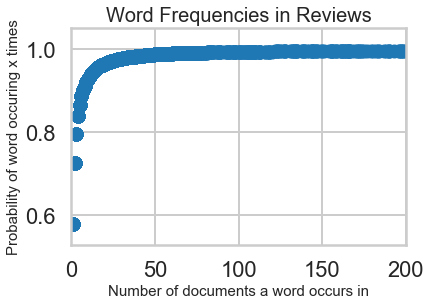

In [30]:
# Plot the Construct the cumulative distribution of document frequencies (df). 
# The  x-axis is a document count  xi  and the  y-axis is the percentage 
# of words that appear less than  xi  times. For example, at  x=5 , plot 
# a point representing the percentage or number of words that appear in 5 or fewer documents.

def Cdf(t, x):
    count = 0.0
    for word, value in t.items():
        if value <= x:
            count += 1.0

    prob = count / len(occurrences)
    return prob

x_values = []
y_values = []

for word, value in occurrences.items():
    x_values.append(value)
    y_values.append(Cdf(occurrences, value))

plt.title("Word Frequencies in Reviews", fontsize = 20)
plt.ylabel("Probability of word occuring x times", fontsize = 15)
plt.xlabel("Number of documents a word occurs in", fontsize = 15)    
plt.scatter(x_values, y_values)
plt.xlim((0,200))
plt.show()

#### Approach 2

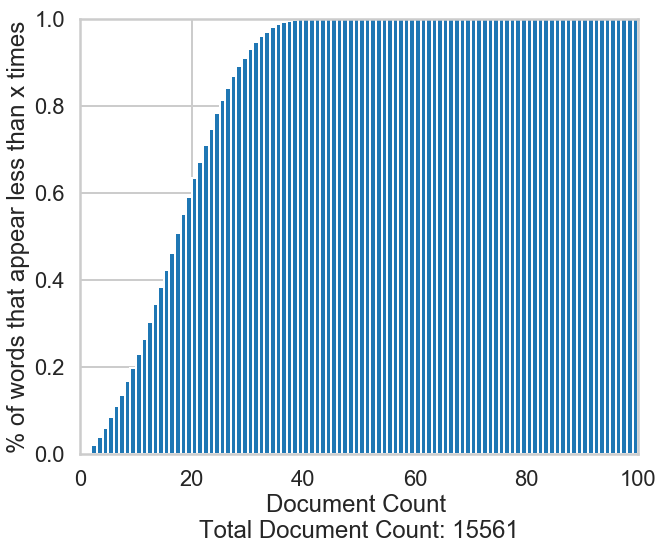

In [31]:
from collections import Counter
vectorizer = CountVectorizer()
X_vec = vectorizer.fit_transform(critics.quote)
document_count = Counter(X_vec.tocsc().indices).values() # compressed sparse columns

plt.figure(figsize=(10, 8))
plt.hist(document_count, alpha = 1, bins=range(1000), cumulative = True, density = 1)
plt.axis([0, 100, 0, 1])

plt.xlabel('Document Count '+ '\n'+'Total Document Count: '  + str(len(document_count)))
plt.ylabel("% of words that appear less than x times")
plt.show()

In [32]:
x

<3x4 sparse matrix of type '<class 'numpy.int64'>'
	with 7 stored elements in Compressed Sparse Row format>

In [33]:
x.toarray()

array([[1, 0, 1, 1],
       [1, 1, 0, 1],
       [3, 0, 0, 0]])

In [34]:
x.tocsc().todense()

matrix([[1, 0, 1, 1],
        [1, 1, 0, 1],
        [3, 0, 0, 0]], dtype=int64)

In [35]:
x.tocsc().sum(axis=0)

matrix([[5, 1, 1, 2]])

In [36]:
x.tocsr().sum(axis=0)

matrix([[5, 1, 1, 2]], dtype=int64)

In [37]:
x.tocsc().sum(axis=1)

matrix([[3],
        [3],
        [3]], dtype=int64)

In [38]:
x.tocsr().sum(axis=1)

matrix([[3],
        [3],
        [3]])

In [39]:
x.tocsc().indices

array([0, 1, 2, 1, 0, 0, 1], dtype=int32)

In [40]:
len(x.tocsc().indices)

7

In [41]:
x.tocsr().indices

array([0, 2, 3, 0, 1, 3, 0], dtype=int32)

In [42]:
len(x.tocsr().indices)

7

In [43]:
Counter(x.tocsc().indices)

Counter({0: 3, 1: 3, 2: 1})

In [44]:
Counter(x.tocsc().indices).values()

dict_values([3, 3, 1])

In [45]:
Counter(x.tocsc().indices).keys()

dict_keys([0, 1, 2])

In [46]:
Counter(x.tocsr().indices)

Counter({0: 3, 1: 1, 2: 1, 3: 2})

In [47]:
Counter(x.tocsr().indices).values()

dict_values([3, 1, 1, 2])

> Since we are interested in column sum to determine frequency of each feature so we use 
`x.tocsr()`

> At approximately 2 documents is where the curve begins climbing steeply. This may be a good value for min_df. 

> At approximately 35-40 documents is where the curve starts to plateau. This may be a good value for max_df. 
>
> `min_df` could be around 0.001 

In [48]:
X_vec

<15561x22417 sparse matrix of type '<class 'numpy.int64'>'
	with 272265 stored elements in Compressed Sparse Row format>

In [49]:
X_vec.tocsr().sum(axis=0).ravel()

matrix([[ 8,  1, 10, ...,  3,  1,  1]], dtype=int64)

In [50]:
X_vec.sum(axis=1)

matrix([[24],
        [ 5],
        [12],
        ..., 
        [35],
        [25],
        [21]])

> Notice the difference at result as we changed compressed matrix format column to row! 

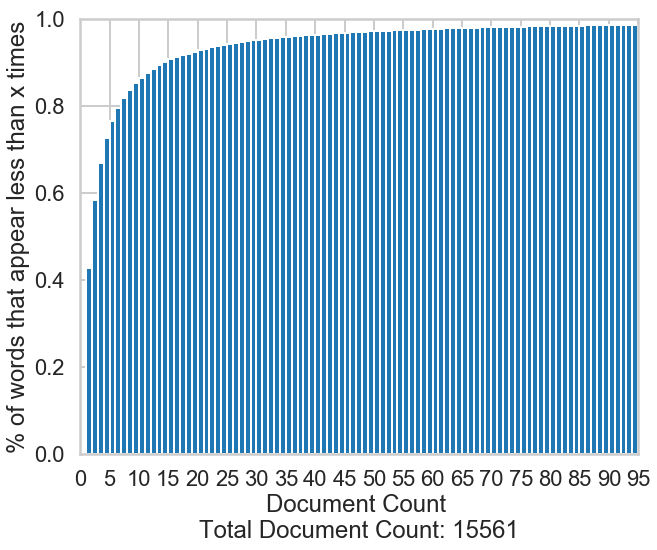

In [51]:
from collections import Counter
vectorizer = CountVectorizer()
X_vec = vectorizer.fit_transform(critics.quote)
total_appearance = Counter(X_vec.tocsr().indices).values() # compressed Sparse Row

plt.figure(figsize=(10, 8))
plt.hist(total_appearance, bins = range(1000), alpha = 1, cumulative = True, density = 1)
plt.axis([0,11,0,1])
plt.xticks(range(0,100,5))

plt.xlabel('Document Count '+ '\n'+'Total Document Count: '  + str(len(document_count)))
plt.ylabel("% of words that appear less than x times")
plt.show()

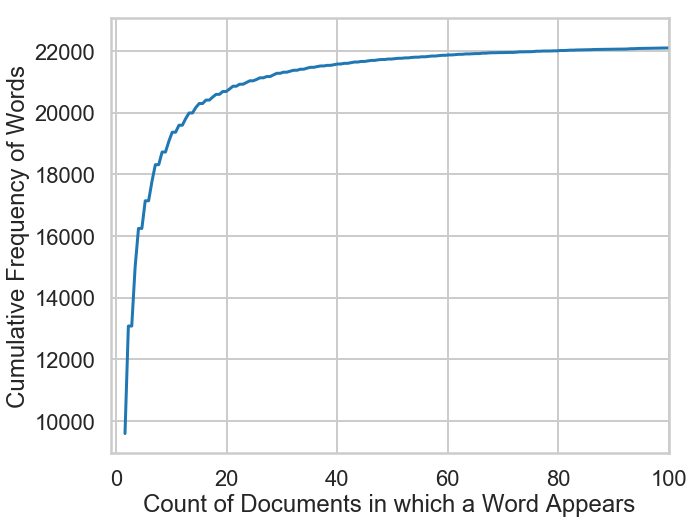

In [52]:
from collections import Counter
from matplotlib.ticker import PercentFormatter


vectorizer = CountVectorizer()
X_vec = vectorizer.fit_transform(critics.quote)
total_number_of_docs = Counter(X_vec.tocsc().indices)
total_appearance = Counter(X_vec.tocsr().indices).values() # compressed Sparse Row

# Compute the frequency of words that appear in exactly k documents
freq, bins = np.histogram(list(total_appearance), bins=len(total_number_of_docs))
cumfreq = np.cumsum(freq)

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(bins[1:], cumfreq)
ax.set_xlim([-1,100])
ax.set_xlabel('Count of Documents in which a Word Appears')
ax.set_ylabel('Cumulative Frequency of Words')
plt.show()

In [53]:
# 2nd fastest
# Column sum to get total number of appearance per each feature
#word_count = sorted([sum(x) for x in zip(*X_arr)])

In [54]:
# # Very slow
# vals_length = len(X_arr[0])
# output_val = [0]*vals_length # init empty output array with 0's
# for i in range(vals_length): # iterate for each index in the array
#     for vals in X_arr:
#         output_val[i] += vals[i] # add to the same index

In [55]:
#xdf = pd.DataFrame(X_arr)
#word_count = xdf.sum(axis=0)

#### Approach 3

In [56]:
# Total number of appearance of each feature
word_appeared = pd.Series(np.sum(X, axis=0).tolist()[
                          0], name='Appearance_Count')

In [57]:
# Count number of rows (documents) that has at least one word
docs = pd.Series(np.sum(X, axis=1).ravel().tolist()
                 [0], name='Total_Words_Per_Doc')

In [58]:
# Cumulative Distribution of "Feature (word) usage < document_number"
temp = []
for i in range(len(docs)):
    # number of words appeared in i or less document
    k = word_appeared[word_appeared <= i].count()
    temp.append(k)
appearance = pd.Series(temp)

In [59]:
appearance.index

RangeIndex(start=0, stop=15561, step=1)

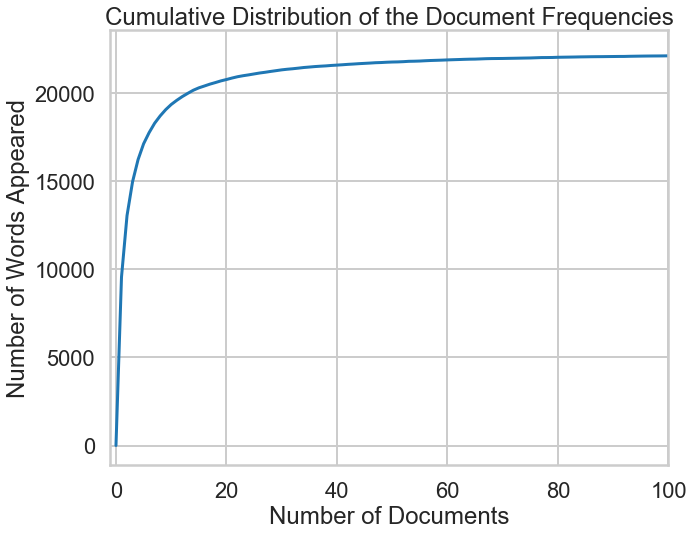

In [60]:
# plot the word count versus number of documents
plt.figure(figsize=(10, 8))
plt.plot(appearance.index, appearance)
# blow up the plot around the curve
plt.xlim([-1, 100])
# add labels
plt.title('Cumulative Distribution of the Document Frequencies')
plt.ylabel('Number of Words Appeared')
plt.xlabel('Number of Documents')
plt.show()

> **Bottom Line:** 
>
>  `min_df` is used to determine terms that are too rare, and `max_df` is used to determine terms that are too common. Out of a total of 22417 words, 95% of them appear in only one document, the curve is steepest between x=0 and 1.We may pick $0.2$ for `min_df`. To find `max_df`, we look at the curve where it begins to flatten out, `0.9` could be the `max_df`.
>
> 
> Note: A cumulative histogram is a mapping that counts the cumulative number of observations in all of the bins up to the specified bin.

#### Approach 4

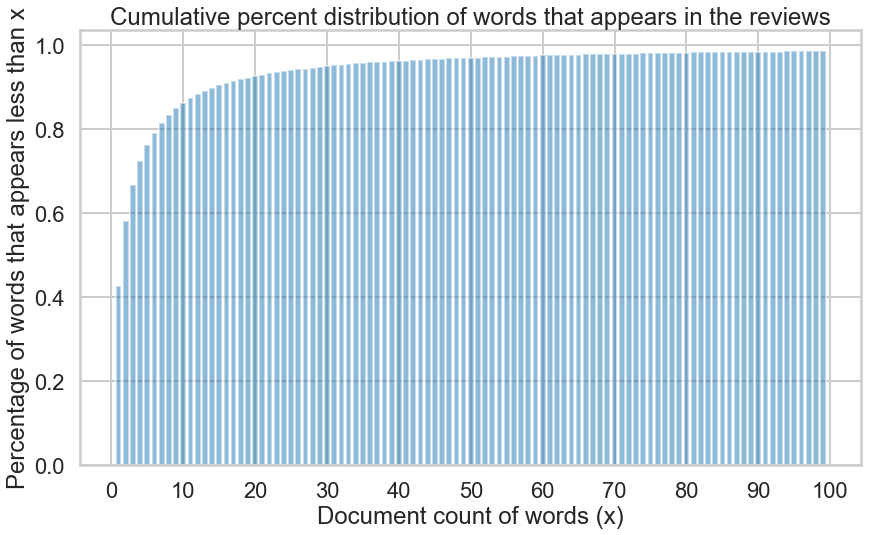

In [170]:
# Your turn.
# contruct the frequency of words
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(critics.quote)
word_freq_df = pd.DataFrame({'term': vectorizer.get_feature_names(), 'occurrences':np.asarray(X.sum(axis=0)).ravel().tolist()})
word_freq_df['frequency'] = word_freq_df['occurrences']/np.sum(word_freq_df['occurrences'])
word_freq_sorted=word_freq_df.sort_values('occurrences', ascending = False)
word_freq_sorted.reset_index(drop=True, inplace=True)
sum_words = len(word_freq_sorted) # 22417 total features

# create the cum frequency distribution
saved_cnt=0
df=[]
for i in range(1, 100):  # word appearance count across all documents 
    prev_cnt = len(word_freq_sorted[word_freq_sorted['occurrences']==i]) # count of appearances of words
    saved_cnt += prev_cnt
    if i==1:
        df=pd.DataFrame([[i, prev_cnt, prev_cnt, prev_cnt/sum_words]], columns=['x', 'freq','cumfreq', 'percent'])
    else:
        df2=pd.DataFrame([[i, prev_cnt, saved_cnt, saved_cnt/sum_words]], columns=['x', 'freq','cumfreq', 'percent']) 
        df = df.append(df2, ignore_index=True) # populate the index do not keep index of df2

# create the bar grapp
plt.figure(figsize=(14,8))
plt.bar(df.x, df.percent, align='center', alpha=0.5)
plt.xticks(list(range(0,101,10)))
plt.ylabel('Percentage of words that appears less than x')
plt.xlabel('Document count of words (x)')
plt.title('Cumulative percent distribution of words that appears in the reviews')
 
plt.show()

The parameter $\alpha$ is chosen to be a small value that simply avoids having zeros in the probability computations. This value can sometimes be chosen arbitrarily with domain expertise, but we will use K-fold cross validation. In K-fold cross-validation, we divide the data into $K$ non-overlapping parts. We train on $K-1$ of the folds and test on the remaining fold. We then iterate, so that each fold serves as the test fold exactly once. The function `cv_score` performs the K-fold cross-validation algorithm for us, but we need to pass a function that measures the performance of the algorithm on each fold. 

In [61]:
from sklearn.model_selection import KFold


def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    # split data into train/test groups, 5 times
    for train, test in KFold(nfold).split(X):
        clf.fit(X[train], y[train])  # fit the classifier, passed is as clf.
        # evaluate score function on held-out data
        result += scorefunc(clf, X[test], y[test])
    return result / nfold  # average

We use the log-likelihood as the score here in `scorefunc`. The higher the log-likelihood, the better. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

Since Naive Bayes classifiers are often used in asymmetric situations, it might help to actually maximize probability on the validation folds rather than just accuracy.

The custom scoring function `scorefunc` allows us to use different metrics depending on the decision risk we care about (precision, accuracy, profit etc.) directly on the validation set. You will often find people using `roc_auc`, precision, recall, or `F1-score` as the scoring function.

In [62]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

We'll cross-validate over the regularization parameter $\alpha$.

Let's set up the train and test masks first, and then we can run the cross-validation procedure.

In [63]:
from sklearn.model_selection import train_test_split
itrain, itest = train_test_split(range(critics.shape[0]), test_size=0.3)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True

In [64]:
len(itest)/(len(itrain)+len(itest))

0.30004498425551057

<div class="span5 alert alert-info">
<h3>Exercise Set IV</h3>

<p><b>Exercise:</b> What does using the function `log_likelihood` as the score mean? What are we trying to optimize for?</p>

<p><b>Exercise:</b> Without writing any code, what do you think would happen if you choose a value of $\alpha$ that is too high?</p>

<p><b>Exercise:</b> Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.</p>
</div>

> The likelihood function is central to the process of estimating the unknown parameters.
Older and less sophisticated methods include the method of moments, and the method
of minimum chi-square for count data. These estimators are not always efficient, and
their sampling distributions are often mathematically intractable.
>
> The likelihood is a function that associates to each parameter the probability (or probability density) of observing the given sample. We just take the log of it. Logarithm transforms a product of densities into a sum. 
>
>If we compare the likelihood function at two parameter points and find that  
>
>$$L(\theta_1 \vert x) > L(\theta_2 \vert x)$$
>then $\theta_1$ is more pluasible value for the parameter $\theta$ than $\theta_2.$

> If happened to choose too high value for $\alpha$, the vocabulary would be missing some features might have an impact on model.
>
> $\alpha$ is an additive (Laplace/Lidstone) smoothing parameter, a larger $\alpha$ will reduce the variance of the model (and overfitting) but increase bias at the same time. We can think of $\alpha$ as a pseudocount of the number of times a word has been seen.

In [65]:
from sklearn.naive_bayes import MultinomialNB

# the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
best_min_df = None  # YOUR TURN: put your value of min_df here.
min_dfs = [.00001, .0001, .001, .01, .2]

score_handler = []
# Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore = -np.inf
for alpha in alphas:
    for min_df in min_dfs:
        vectorizer = CountVectorizer(min_df=min_df)
        Xthis, ythis = make_xy(critics, vectorizer)
        Xtrainthis = Xthis[mask]
        ytrainthis = ythis[mask]

        # Cross validate the NB model and compute the best average score
        clf = MultinomialNB(alpha=alpha)
        score = cv_score(clf, Xtrainthis, ytrainthis, scorefunc=log_likelihood)
        score_handler.append(score)

        if score > maxscore:
            maxscore = score
            best_alpha = alpha
            best_min_df = min_df

In [66]:
print("Best alpha: {}\nBest min_df: {} \n\
Best Score: {}".format(best_alpha, best_min_df, maxscore))

Best alpha: 5
Best min_df: 0.001 
Best Score: -559.8876420460814


In [67]:
print(sorted(score_handler))

[-1471.8674156648481, -1413.334435861972, -1358.3540996525435, -1315.1596111653521, -1270.8510223952442, -1042.7892936998146, -1021.3662646944255, -961.3113147641252, -954.72959482164845, -749.50638342533534, -721.35765319938696, -647.97017977004396, -632.61162488645436, -625.14686536408828, -617.24871625969547, -617.19931546090686, -617.19880865984624, -617.19730933161463, -617.19708758615855, -594.72189649460665, -593.17307787889308, -589.35021297569187, -588.3650381305772, -578.61409088232119, -559.8876420460814]


<div class="span5 alert alert-info">
<h3>Exercise Set V: Working with the Best Parameters</h3>

<p><b>Exercise:</b> Using the best value of  `alpha` you just found, calculate the accuracy on the training and test sets. Is this classifier better? Why (not)?</p>

</div>

In [68]:
# mask is True for test set
len(mask)

15561

In [69]:
vectorizer = CountVectorizer(min_df=best_min_df)  # Remove some words(features)
X, y = make_xy(critics, vectorizer)  # X (15561,2120) y (15561)
xtrain = X[mask]
ytrain = y[mask]
xtest = X[~mask]
ytest = y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

# your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.798244
Accuracy on test data:     0.712358


> Looks like less accurate, but we reduced the overfitting problem.

Thus in binary classification, the count of true negatives is $C_{0,0}$, false negatives is  $C_{1,0}$, true positives is  $C_{1,1}$ and false positives is  $C_{0,1}$.

In [70]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(ytest, clf.predict(xtest)).ravel()
(tn, fp, fn, tp)

(2037, 2250, 883, 5722)

## Interpretation

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

> If we run model with xtest we would have gotten huge probability matrix which is hard to understand.

In [71]:
xtest.shape[1]

2120

In [72]:
# Get feature names of size 2120 using the best_min_df
words = np.array(vectorizer.get_feature_names())

# create an identity matrix with the number of features
x = np.eye(xtest.shape[1])
# the model's probabilities of prediciting rotten reviews
probs = clf.predict_log_proba(x)[:, 0]
# Returns the indices based on sorting the predicted probabilities in descending 
# First index belongs to the smallest element in an array
ind = np.argsort(probs)


good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]


print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    

print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
           fashioned 0.85
               smart 0.84
               witty 0.84
        entertaining 0.84
         masterpiece 0.84
               great 0.83
             perfect 0.83
                rare 0.82
               today 0.82
       entertainment 0.81
Bad words	     P(fresh | word)
               video 0.30
               awful 0.29
               bland 0.29
               fails 0.29
          uninspired 0.28
              forced 0.27
               feels 0.27
       unfortunately 0.21
                flat 0.20
                dull 0.17


>$$log(P(class_i| data))∝log(P(class_i))+∑_jlog(P(data_j|class_i))$$
>
> We should expect to get values between $0$ and $1$ from probability functions so their $Log$ would be between $-\infty$ and $0$.

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Why does this method work? What does the probability for each row in the identity matrix represent</p>

</div>

> `np.eye` creates an Identity matrix with the size of the number of features in test set which is $2120$. Each feature fitted in the model obtained fitting the training set to compare the outcomes with corresponding True values. If a feature/word has a high probability of being in a particular class, then  this could interpreted as high predictive power of the feature.So, that implies the feature is important for the model. 

The above exercise is an example of *feature selection*. There are many other feature selection methods. A list of feature selection methods available in `sklearn` is [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). The most common feature selection technique for text mining is the chi-squared $\left( \chi^2 \right)$ [method](http://nlp.stanford.edu/IR-book/html/htmledition/feature-selectionchi2-feature-selection-1.html).

### Prediction Errors

We can see mis-predictions as well.

In [73]:
len(y)

15561

In [74]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

Mis-predicted Rotten quotes
---------------------------
Walken is one of the few undeniably charismatic male villains of recent years; he can generate a snakelike charm that makes his worst characters the most memorable, and here he operates on pure style.

The plot of The Glimmer Man involves not only the Family Man but Our Evil Secret Government, the Russian Mafia and Rich Powerful Politicians -- the three stooges of action cinema in the '90s.

It is sometimes funny in a puzzling kind of way, it is generally overwrought in an irritating kind of way, and once in a while it is inappropriately touching.

The Disney organization is worst when it makes "family entertainment" and best when it sticks to pure, simple, charming fantasy.

With its feints at horror and pathos, the third Star Wars film is the most Disney-esque in its emotional outline, yet that outline is buried beneath an obnoxiously hyped-up pace that reduces the emotions to rubble.

Mis-predicted Fresh quotes
----------------

<div class="span5 alert alert-info">
<h3>Exercise Set VII: Predicting the Freshness for a New Review</h3>
<br/>
<div>
<b>Exercise:</b>
<ul>
<li> Using your best trained classifier, predict the freshness of the following sentence: *'This movie is not remarkable, touching, or superb in any way'*
<li> Is the result what you'd expect? Why (not)?
</ul>
</div>
</div>

In [75]:
# Transform the text with Vectorizer
new_text = ['This movie is not remarkable, touching, or superb in any way']
vectorized_text = vectorizer.transform(new_text)
new_probs = clf.predict_log_proba(vectorized_text)
predicted_class = clf.predict(vectorized_text) 
print(('Class Probabilities:',np.exp(new_probs)))
print(('Predicted Class:', predicted_class))

Class Probabilities: [[ 0.04530195  0.95469805]]
Predicted Class: [1]


> This is bad! Given rotten review is translated into a fresh review with $95 %$ probability!!

### Aside: TF-IDF Weighting for Term Importance

TF-IDF stands for 

`Term-Frequency X Inverse Document Frequency`.

In the standard `CountVectorizer` model above, we used just the term frequency in a document of words in our vocabulary. In TF-IDF, we weight this term frequency by the inverse of its popularity in all documents. For example, if the word "movie" showed up in all the documents, it would not have much predictive value. It could actually be considered a stopword. By weighing its counts by 1 divided by its overall frequency, we downweight it. We can then use this TF-IDF weighted features as inputs to any classifier. **TF-IDF is essentially a measure of term importance, and of how discriminative a word is in a corpus.** There are a variety of nuances involved in computing TF-IDF, mainly involving where to add the smoothing term to avoid division by 0, or log of 0 errors. The formula for TF-IDF in `scikit-learn` differs from that of most textbooks: 

$$\mbox{TF-IDF}(t, d) = \mbox{TF}(t, d)\times \mbox{IDF}(t) = n_{td} \log{\left( \frac{\vert D \vert}{\vert d : t \in d \vert} + 1 \right)}$$

where $n_{td}$ is the number of times term $t$ occurs in document $d$, $\vert D \vert$ is the number of documents, and $\vert d : t \in d \vert$ is the number of documents that contain $t$

> For example, if the word "movie" showed up in all the documents, it would not have much predictive value. By weighing its counts by 1 divides by its overall frequency, we down-weight it. We can then use this tfidf weighted features as inputs to any classifier. 
> 
> Simply the LOG part reduces the effect of word if it is spread all over the document. Word(s) like that would not be good separator or would not help the classifier.

**QUESTION**

> document $d$: 
>
> how do we calculate $n_{td}$ ?

**ANSWER**

>

In [76]:
# http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
# http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(stop_words='english')
Xtfidf = tfidfvectorizer.fit_transform(critics.quote)

In [77]:
tfidfvectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [78]:
Xtfidf

<15561x22125 sparse matrix of type '<class 'numpy.float64'>'
	with 156947 stored elements in Compressed Sparse Row format>

<div class="span5 alert alert-info">
<h3>Exercise Set VIII: Enrichment <b>(Optional)</b></h3>

<p>
There are several additional things we could try. Try some of these as exercises:
<ol>
<li> Build a Naive Bayes model where the features are n-grams instead of words. N-grams are phrases containing n words next to each other: a bigram contains 2 words, a trigram contains 3 words, and 6-gram contains 6 words. This is useful because "not good" and "so good" mean very different things. On the other hand, as n increases, the model does not scale well since the feature set becomes more sparse.
<li> Try a model besides Naive Bayes, one that would allow for interactions between words -- for example, a Random Forest classifier.
<li> Try adding supplemental features -- information about genre, director, cast, etc.
<li> Use word2vec or [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to group words into topics and use those topics for prediction.
<li> Use TF-IDF weighting instead of word counts.
</ol>
</p>

<b>Exercise:</b> Try at least one of these ideas to improve the model (or any other ideas of your own). Implement here and report on the result. 
</div>

####  Answer to 1 & 2 & 5

**With TF-IDF**

In [83]:
# Step 1: Apply vectorizer with bi-grams
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=best_min_df, stop_words='english',
                                  ngram_range=(1, 3))

# Apply Vectorizer
X_new = tfidfvectorizer.fit_transform(critics['quote'])
y_new = (critics.fresh == 'fresh').values.astype(np.int)

In [84]:
# Step 2: Split data into train and test
from sklearn.model_selection import train_test_split
xtr, xtst, ytr, ytst = train_test_split(X_new, y_new, test_size=0.3,
                                        random_state=42)

In [149]:
# Step 3: Pick and fit your classifier to see which one performs better
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier


# Dictionary of classifiers key=name, value=(line format, classifier)
class_map = {
    'LogisticRegression': ('-', LogisticRegression()),
    'Multinomial NB': ('--', MultinomialNB()),
    'Decision Tree': ('.-', DecisionTreeClassifier()),
    'Random Forest': (':', RandomForestClassifier()),
    'SVM' : ('-', SGDClassifier(loss='log', penalty='l2',
                                 alpha=1e-3, random_state=42,
                                 max_iter=5, tol=None))
}

Accuracy on training: 0.7811237605582079 with using Multinomial NB
Accuracy on testing: 0.7301349325337332 with using Multinomial NB
------------------------
Accuracy on training: 0.9761292691883952 with using Random Forest
Accuracy on testing: 0.6864424930391947 with using Random Forest
------------------------
Accuracy on training: 0.9920124862284245 with using Decision Tree
Accuracy on testing: 0.6481045191689869 with using Decision Tree
------------------------
Accuracy on training: 0.798108703635696 with using LogisticRegression
Accuracy on testing: 0.741272221032341 with using LogisticRegression
------------------------
Accuracy on training: 0.6659933896437753 with using SVM
Accuracy on testing: 0.6551724137931034 with using SVM
------------------------


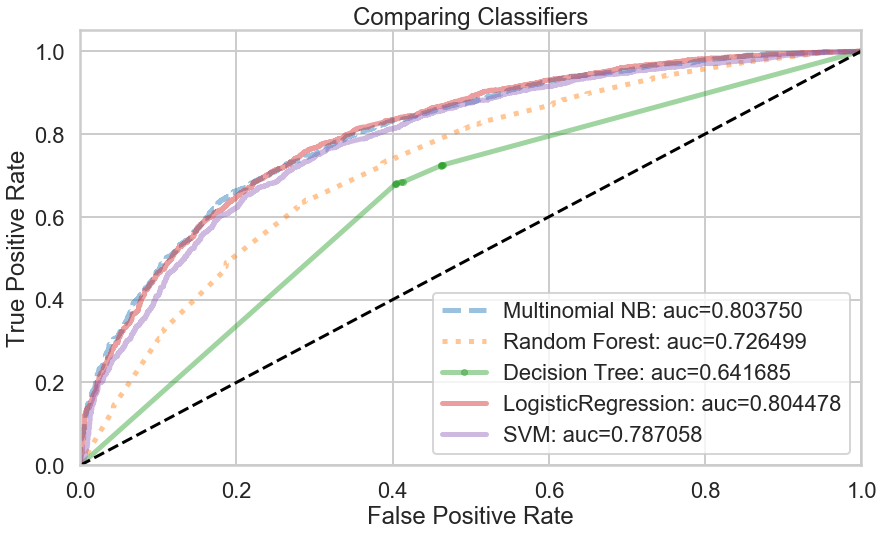

In [728]:
# Step 4: Call metrics, apply models and evaluate models
#from sklearn.metrics import roc_curve, auc
from sklearn import metrics

plt.figure(figsize=(14, 8))
for name, (line_for, model) in class_map.items():
    model.fit(xtr, ytr)

    # Array of predictions
    preds = model.predict_proba(xtst)
    prediction = pd.Series(preds[:, 1])

    # Get data for metrics
    fpr, tpr, thresholds = roc_curve(ytst, prediction)
    auc_score = auc(fpr, tpr)
    labels = '%s: auc=%f' % (name, auc_score)
    plt.plot(fpr, tpr, line_for, linewidth=5, label=labels, alpha=0.45)

    # Print Scores
    print('Accuracy on training: {} with using {}'.format(
        model.score(xtr, ytr), name))
    print('Accuracy on testing: {} with using {}'.format(
        model.score(xtst, ytst), name))
#     f1_score = metrics.f1_score(ytst, prediction)
#     print('F_1 score: {}'.format(f1_score))
    print('------------------------')

plt.legend(loc='lower right')
plt.title('Comparing Classifiers')
plt.plot([0, 1], [0, 1], 'k--')  # x=y line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('Test1')
plt.show()

> Random Forest and Decision Tree shows over fitting based on accuracy results on tarining and test data. Among all four models the `LogisticRegression` and `MultinomialNB` perform better than the others.

In [151]:
# Step 5: Final results with classification reports
from sklearn.metrics import classification_report

for name, (line_for, model) in class_map.items():
    # Fit
    model.fit(xtr, ytr)

    # Array of predictions
    preds = model.predict_proba(xtst)
    prediction = pd.Series(preds[:, 1])

    # Classification Report
    print(classification_report(y_true=ytst, y_pred=prediction))

ValueError: Mix type of y not allowed, got types {'binary', 'continuous'}

In [152]:
# Step 5: Final results with classification reports
import model_evaluation_utils as meu

for name, (line_for, model) in class_map.items():
    # Fit
    model.fit(xtr, ytr)

    # Array of predictions
    preds = model.predict_proba(xtst)
    prediction = pd.Series(preds[:, 1])

    # Classification Report
    print(classification_report(y_true=ytst, y_pred=prediction))

ValueError: Mix type of y not allowed, got types {'binary', 'continuous'}

**With CountVectorizer**

Accuracy on training: 0.8361533518954808 with using Multinomial NB
Accuracy on testing: 0.7224568490635329 with using Multinomial NB
Accuracy on training: 0.9860783893767402 with using Random Forest
Accuracy on testing: 0.6376239441792141 with using Random Forest
Accuracy on training: 0.9978582137502677 with using Decision Tree
Accuracy on testing: 0.5930040396621373 with using Decision Tree
Accuracy on training: 0.8896980081387877 with using LogisticRegression
Accuracy on testing: 0.7156628718325376 with using LogisticRegression
Accuracy on training: 0.8327264938959091 with using SVM
Accuracy on testing: 0.7062063900110173 with using SVM


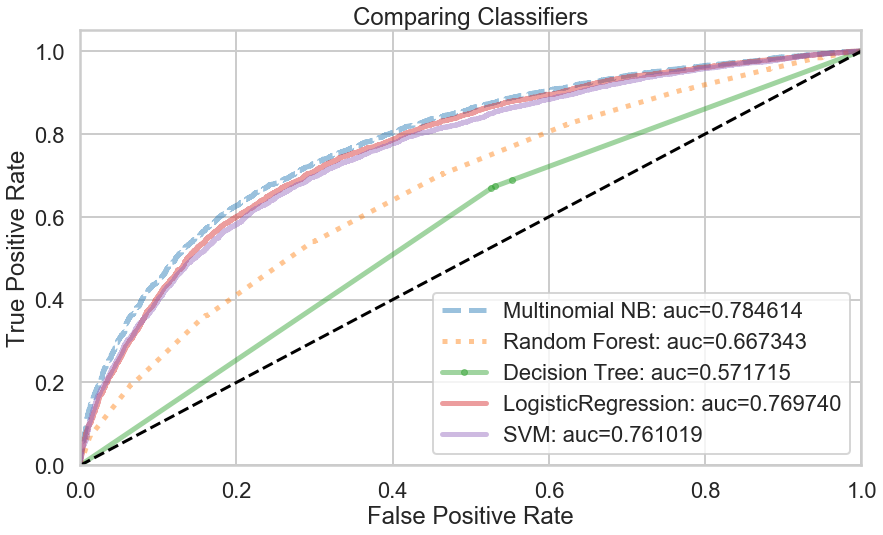

In [153]:
# New testing with the Last Vectorizer
from sklearn.metrics import roc_curve, auc
the_last_vectorizer = CountVectorizer(min_df=best_min_df, ngram_range=(1, 4))
X, y = make_xy(critics, vectorizer)
xtrain = X[mask]
ytrain = y[mask]
xtest = X[~mask]
ytest = y[~mask]

# Step 4: Call metrics, apply models and evaluate models
plt.figure(figsize=(14, 8))
for name, (line_for, model) in class_map.items():
    model.fit(xtrain, ytrain)

    # Array of predictions
    preds = model.predict_proba(xtest)
    prediction = pd.Series(preds[:, 1])

    # Get data for metrics
    fpr, tpr, thresholds = roc_curve(ytest, prediction)
    auc_score = auc(fpr, tpr)
    labels = '%s: auc=%f' % (name, auc_score)
    plt.plot(fpr, tpr, line_for, linewidth=5, label=labels, alpha=0.45)

    # Print Scores
    print('Accuracy on training: {} with using {}'.format(
        model.score(xtrain, ytrain), name))
    print('Accuracy on testing: {} with using {}'.format(
        model.score(xtest, ytest), name))

plt.legend(loc='lower right')
plt.title('Comparing Classifiers')
plt.plot([0, 1], [0, 1], 'k--')  # x=y line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [267]:
# Step 5: Final results with classification reports
from sklearn.metrics import classification_report

for name, (line_for, model) in class_map.items():
    # Fit
    model.fit(xtrain, ytrain)

    # Array of predictions
    preds = model.predict_proba(xtest)
    prediction = pd.Series(preds[:, 1])

    # Classification Report
    print(classification_report(y_true=ytest, y_pred=prediction))

ValueError: Mix type of y not allowed, got types {'continuous', 'binary'}

**Logistic Regression & Parameter Tuning**

In [122]:
# Step 6: Parameter Tuning for LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

X_ = critics['quote']
y_ = (critics['fresh']=='fresh').values.astype(np.int)
train_X, test_X, train_y, test_y = train_test_split(X_, y_, test_size=0.3,
                                                   random_state=42)

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', LogisticRegression()),
    
])

parameters = {
    'vect__min_df': [.001, .01, .1],
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__C': [.1, 1, 5, 10]
}


grid_search = GridSearchCV(pipeline, parameters, cv=5)

In [154]:
# Step 6: Parameter Tuning 
def evaluate(grid_search, Xtrain, Xtest, ytrain, ytest):
    # Fit Grid Search
    clf = grid_search.fit(Xtrain, ytrain)
    
    # Print Best Scores
    print(("Best score:  {}".format(clf.best_score_))) # Mean CV score of the best estimator
    print("Best parameters set:")
    # estimator which gave highest score on the left out data
    best_parameters = clf.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print(("\t{}: {}".format(param_name, best_parameters[param_name])))
    
    # Accuracy
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print(("Accuracy on training data: {:2f}".format(training_accuracy)))
    print(("Accuracy on test data:     {:2f}".format(test_accuracy)))
    
    # Metric for classification performence
    from sklearn.metrics import confusion_matrix
    print('Connfusion Matrix: \n',confusion_matrix(ytest, clf.predict(Xtest)))

In [155]:
# Step 6: Results
evaluate(grid_search, train_X, test_X, train_y, test_y)

Best score:  0.7343922144693353
Best parameters set:
	clf__C: 1
	vect__min_df: 0.001
	vect__ngram_range: (1, 1)
Accuracy on training data: 0.836394
Accuracy on test data:     0.742771
Connfusion Matrix: 
 [[1110  684]
 [ 517 2358]]


>''Remember that we use paramter C as our regularization parameter. Parameter C = 1/λ.
Lambda (λ) controls the trade-off between allowing the model to increase it's complexity as much as it wants with trying to keep it simple. For example, if λ is very low or 0, the model will have enough power to increase it's complexity (overfit) by assigning big values to the weights for each parameter. If, in the other hand, we increase the value of λ, the model will tend to underfit, as the model will become too simple.
Parameter C will work the other way around. For small values of C, we increase the regularization strength which will create simple models which underfit the data. For big values of C, we low the power of regularization which imples the model is allowed to increase it's complexity, and therefore, overfit the data.'' [source](https://www.kaggle.com/joparga3/2-tuning-parameters-for-logistic-regression)

####  Answer to 3: Try adding supplemental features -- information about genre, director, cast, etc.

#### Answer to 4: Use word2vec or [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to group words into topics and use those topics for prediction.

**LDA** is a type of statistical modeling that is used to discover 'topics' in a document. It provides classification model topic per document and words per topics.

We will perform the following steps:

- Tokenization: Split the text into sentences and the sentences into words. 
- Lowercase the words and remove punctuation.
- Words that have fewer than 3 characters are removed.
- All stopwords are removed.
- Words are lemmatized — words in third person are changed to first person and verbs in past and future tenses are changed into present.
- Words are stemmed — words are reduced to their root form.

Another [source on LDA](https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-latent-dirichlet-allocation-437c81220158)

Other [source on Topic Modeling](https://medium.com/nanonets/topic-modeling-with-lsa-psla-lda-and-lda2vec-555ff65b0b05)

> **Stemming** usually refers to a crude process that chops off the ends of words in the hope of achieving this goal correctly most of the time, and often includes the removal of derivational units (the obtained element is known as the stem).
>
>**Lemmatization** consists in doing things properly with the use of a vocabulary and morphological analysis of words, to return the base or dictionary form of a word, which is known as the lemma
>
> `am | is | are` ----Stem-----> `be`
>
> I `saw` an amazing thing `---Stem---->` I `s` an amazing thing
>
> I `saw` an amazing thing `--Lemmatize-->` I `see` an amazing thing
>
>both techniques could remove important information but also help us to normalize our corpus (although lemmatization is the one that is usually applied)

In [212]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(42)
stemmer = PorterStemmer()

import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/macos/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [213]:
# Lemmatize
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

In [268]:
# Removing conditions 
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) >3:
            result.append(lemmatize_stemming(token))
    return result

In [269]:
# After preprocessing take a look at one sentence/sample
documents = critics['quote'].values
doc_sample = documents[0]

print('original document: ')
words = []
for word in doc_sample.split():
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['So', 'ingenious', 'in', 'concept,', 'design', 'and', 'execution', 'that', 'you', 'could', 'watch', 'it', 'on', 'a', 'postage', 'stamp-sized', 'screen', 'and', 'still', 'be', 'engulfed', 'by', 'its', 'charm.']


 tokenized and lemmatized document: 
['ingeni', 'concept', 'design', 'execut', 'watch', 'postag', 'stamp', 'size', 'screen', 'engulf', 'charm']


> Seems like there are some weird words derived from stemming i.e. `postag` , `execut` and `ingeni`. Stopwords are gone! 

In [312]:
# Create a dictionary from processed documents containing number of occurances
processed_txt = critics['quote'].map(preprocess)
dictionary = gensim.corpora.Dictionary(processed_txt)


In [317]:
processed_txt.head(5)

1    [ingeni, concept, design, execut, watch, posta...
2                               [year, invent, comedi]
3                        [win, anim, featur, spectrum]
4    [film, sport, provoc, appeal, stori, equal, te...
5    [entertain, gener, hyperrealist, anim, featur,...
Name: quote, dtype: object

In [275]:
# Remove words appear less than 15 documents or more than 0.05 documents
dictionary.filter_extremes(no_below=15, no_above=0.05)

In [325]:
# For each word create a dictionary that reports how many words\
# and how many times those words appear.
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_txt]

In [334]:
dictionary

In [333]:
bow_corpus[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1)]

In [326]:
# Preview bag of words 
bow_doc_0 = bow_corpus[0]
for i in range(len(bow_doc_4310)):
    print(("Word {} (\"{}\") appears {} time.".format(bow_doc_0[i][0], 
                                               dictionary[bow_doc_0[i][0]],bow_doc_0[i][1])))

Word 0 ("charm") appears 1 time.
Word 1 ("concept") appears 1 time.
Word 2 ("design") appears 1 time.
Word 3 ("engulf") appears 1 time.
Word 4 ("execut") appears 1 time.
Word 5 ("ingeni") appears 1 time.
Word 6 ("postag") appears 1 time.
Word 7 ("screen") appears 1 time.


In [300]:
# Create tf-idf object to weigh features 
from gensim import corpora, models

tfidf = models.TfidfModel(bow_corpus) # input is a list of tuples
corpus_tfidf = tfidf[bow_corpus]

In [307]:
# see weights of first element bow_corpus[0] in preprocessed text 
corpus_tfidf[0]

[(0, 0.2950082989963056),
 (1, 0.37511927403033785),
 (2, 0.33982945822880134),
 (3, 0.36925402157473919),
 (4, 0.43164938439594275),
 (5, 0.26540498754805358),
 (6, 0.43767481607366782),
 (7, 0.26851964091135339)]

In [343]:
# Run LDA using bag of words
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=3,
                               id2word=dictionary, passes=2, workers=2)

# For each topic find the words occuring in that topic and its relative weight
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.019*"movi" + 0.008*"film" + 0.007*"stori" + 0.007*"best" + 0.006*"director" + 0.005*"funni" + 0.004*"like" + 0.004*"comedi" + 0.004*"pictur" + 0.004*"charact"
Topic: 1 
Words: 0.021*"film" + 0.018*"movi" + 0.007*"entertain" + 0.005*"work" + 0.004*"charact" + 0.004*"like" + 0.004*"come" + 0.004*"good" + 0.004*"think" + 0.004*"director"
Topic: 2 
Words: 0.020*"film" + 0.013*"movi" + 0.009*"like" + 0.007*"time" + 0.007*"good" + 0.006*"perform" + 0.005*"comedi" + 0.005*"charact" + 0.005*"littl" + 0.004*"look"


> Distinguishing topics is not easy here, as this is all film reviews. Almost all topics have the similar words. 

In [352]:
# Performance evaluation of LDA with Bag Of Words on classification of sample doc
print((processed_txt.iloc[0])) # our very first sample after pre-processing
print('-----------------')
for index, score in sorted(lda_model[bow_corpus[0]], key=lambda tup: -1*tup[1]):
    print(("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index))))
    print('--------------')

['ingeni', 'concept', 'design', 'execut', 'watch', 'postag', 'stamp', 'size', 'screen', 'engulf', 'charm']
-----------------

Score: 0.931900680065155	 
Topic: 0.021*"film" + 0.018*"movi" + 0.007*"entertain" + 0.005*"work" + 0.004*"charact" + 0.004*"like" + 0.004*"come" + 0.004*"good" + 0.004*"think" + 0.004*"director"
--------------

Score: 0.034644003957509995	 
Topic: 0.019*"movi" + 0.008*"film" + 0.007*"stori" + 0.007*"best" + 0.006*"director" + 0.005*"funni" + 0.004*"like" + 0.004*"comedi" + 0.004*"pictur" + 0.004*"charact"
--------------

Score: 0.03345532715320587	 
Topic: 0.020*"film" + 0.013*"movi" + 0.009*"like" + 0.007*"time" + 0.007*"good" + 0.006*"perform" + 0.005*"comedi" + 0.005*"charact" + 0.005*"littl" + 0.004*"look"
--------------


> Looks like our sample which was first review in `cricitcs.quote` is classisified to be in first `Topic` with $ 93 \% $ probability when we used Bag of Words approach.

In [342]:
# Run LDA using TFIDF 
lda_model_tf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=3,
                                         id2word=dictionary,
                                         passes=2,
                                         workers=4)
for idx, topic in lda_model_tf.print_topics(-1):
      print(('Topic: {} \nWords: {}'.format(idx, topic)))

Topic: 0 
Words: 0.006*"flawless" + 0.006*"life" + 0.005*"size" + 0.004*"appeal" + 0.004*"impress" + 0.004*"lasset" + 0.004*"frequent" + 0.003*"wrong" + 0.003*"screenplay" + 0.003*"bernadin"
Topic: 1 
Words: 0.004*"provoc" + 0.004*"hour" + 0.004*"martin" + 0.003*"flawless" + 0.003*"arguabl" + 0.003*"frequent" + 0.003*"regrett" + 0.003*"progress" + 0.003*"leaven" + 0.003*"screen"
Topic: 2 
Words: 0.004*"gloomi" + 0.004*"size" + 0.003*"martin" + 0.003*"watch" + 0.003*"impress" + 0.003*"appeal" + 0.003*"fulli" + 0.003*"crime" + 0.003*"back" + 0.003*"act"


> Remember Tfidf assigns low weight to words appear more frequent than others.

In [355]:
# Performance evaluation of LDA with TFIDF model on classification of sample doc
print((processed_txt.iloc[0]))
print('----------------')

for index, score in sorted(lda_model_tf[bow_corpus[0]], key=lambda tup: -1*tup[1]):
    print(("\nScore: {}\t \nTopic: {}".format(score, lda_model_tf.print_topic(index, 10))))
    print('----------------')

['ingeni', 'concept', 'design', 'execut', 'watch', 'postag', 'stamp', 'size', 'screen', 'engulf', 'charm']
----------------

Score: 0.7100803852081299	 
Topic: 0.006*"flawless" + 0.006*"life" + 0.005*"size" + 0.004*"appeal" + 0.004*"impress" + 0.004*"lasset" + 0.004*"frequent" + 0.003*"wrong" + 0.003*"screenplay" + 0.003*"bernadin"
----------------

Score: 0.25613483786582947	 
Topic: 0.004*"provoc" + 0.004*"hour" + 0.004*"martin" + 0.003*"flawless" + 0.003*"arguabl" + 0.003*"frequent" + 0.003*"regrett" + 0.003*"progress" + 0.003*"leaven" + 0.003*"screen"
----------------

Score: 0.03378479182720184	 
Topic: 0.004*"gloomi" + 0.004*"size" + 0.003*"martin" + 0.003*"watch" + 0.003*"impress" + 0.003*"appeal" + 0.003*"fulli" + 0.003*"crime" + 0.003*"back" + 0.003*"act"
----------------


> With use of TfIdf the probability of our sample being in the first group is reduced down to $ 71 \%$ 

**Testing LDA model with an unseen text**

In [367]:
unseen_doc = 'This movie is not remarkable, touching, or superb in any way'

# Process the sentence for the LDA analysis
pre_worked = preprocess(unseen_doc)
print(pre_worked)
print('----------------')
# Create a vector
bow_vector = dictionary.doc2bow(pre_worked)
print(bow_vector)
print('----------------')

['movi', 'remark', 'touch', 'superb']
----------------
[(37, 1), (684, 1), (1298, 1), (3042, 1)]
----------------


In [369]:
# Interpreting the vector  above
for i in range(len(bow_vector)):
    print("Word {} (\"{}\") appears {} time.".format(bow_vector[i][0], 
                                               dictionary[bow_vector[i][0]], 
bow_vector[i][1]))

Word 37 ("movi") appears 1 time.
Word 684 ("touch") appears 1 time.
Word 1298 ("superb") appears 1 time.
Word 3042 ("remark") appears 1 time.


In [730]:
for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\nTopic: {}".format(score, lda_model.print_topic(index, 5)))
    print('------')

Score: 0.812061607837677
Topic: 0.020*"film" + 0.013*"movi" + 0.009*"like" + 0.007*"time" + 0.007*"good"
------
Score: 0.1051335334777832
Topic: 0.019*"movi" + 0.008*"film" + 0.007*"stori" + 0.007*"best" + 0.006*"director"
------
Score: 0.08280480653047562
Topic: 0.021*"film" + 0.018*"movi" + 0.007*"entertain" + 0.005*"work" + 0.004*"charact"
------


> With almost $ 82\%$ certainty our LDA approach is classified the unseen text in the first topic. [Refernce: Topic Modeling and LDA](https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24)

#### Word2Vec

> The idea behind Word2Vec is pretty simple. We’re making an assumption that the meaning of a word can be inferred by the company it keeps. Word2Vec model is used for learning vector representations of words called “word embeddings”. 
>
> The secret to getting Word2Vec really working for you is to have lots and lots of text data in the relevant domain.
>
>Word2vec is a group of related models that are used to produce word embeddings. These models are shallow, two-layer neural networks that are trained to reconstruct linguistic contexts of words. Word2vec takes as its input a large corpus of text and produces a vector space, typically of several hundred dimensions, with each unique word in the corpus being assigned a corresponding vector in the space. Word vectors are positioned in the vector space such that words that share common contexts in the corpus are located in close proximity to one another in the space
>
>>Word2Vec uses all these tokens to internally create a vocabulary  which essentially is a set of unique words.
>
> Here, we will train a neural network with a single hidden (latent) layer where we train the model to predict current word based on the context. This provides us the weights of the hidden layer. These weights are simply the word vectors called `embeddings` we were trying to learn. It is basically a combined vector of features that describes the `target` word. 
>
> Word2Vec creates clusters of semantically related words, so another possible approach is to exploit the similarity of words within a cluster
>
> When to use Word2Vec: 
> - If you need to build a sentiment lexicon training word2vec model could help.
> - Beyond raw unstructured text data, you could also use Word2Vec for more structured data.
>
>
> [Reference](http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.XCu59PxOnUI)
> [Reference2](https://arxiv.org/pdf/1301.3781.pdf)
>[Reference3](https://en.wikipedia.org/wiki/Word2vec)
>[Refence4](https://www.kaggle.com/c/word2vec-nlp-tutorial#setting-up-your-system)

> - size: (default 100) The number of dimensions of the embedding, e.g. the length of the dense vector to represent each token (word).
- window: (default 5) The maximum distance between a target word and words around the target word.
- min_count: (default 5) The minimum count of words to consider when training the model; words with an occurrence less than this count will be ignored.
- workers: (default 3) The number of threads to use while training.
- sg: (default 0 or CBOW) The training algorithm, either CBOW (0) or skip gram (1).


[a baby step in Deep Learning](https://medium.com/explore-artificial-intelligence/word2vec-a-baby-step-in-deep-learning-but-a-giant-leap-towards-natural-language-processing-40fe4e8602ba)

In [585]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
# Import the built-in logging module and configure it so that Word2Vec 
# creates nice output messages
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

In [609]:
tokenized = [simple_preprocess(i) for i in critics['quote']]
# Just a view of tokenized form of a sample review
print(tokenized[0])

['so', 'ingenious', 'in', 'concept', 'design', 'and', 'execution', 'that', 'you', 'could', 'watch', 'it', 'on', 'postage', 'stamp', 'sized', 'screen', 'and', 'still', 'be', 'engulfed', 'by', 'its', 'charm']


In [608]:
# Remove typos, multiple words 
min_count = 10
# Size of NN layers corresponds to degrees of freedom the training algorithm has
size = 300 # default 100. Bigger is the better with enough data
# Parallelization
workers = 4 # default 1
# Max distance between the current and predicted word within a sentence
window = 5


word2_model = gensim.models.Word2Vec(tokenized,
                                    min_count=min_count,
                                    window=window,
                                    workers=workers,
                                    size=size)
# Train the model
word2_model.train(tokenized,
                  total_examples=word2_model.corpus_count,
                  epochs=10)

2019-01-02 22:17:21,875 : INFO : collecting all words and their counts
2019-01-02 22:17:21,876 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-01-02 22:17:21,934 : INFO : PROGRESS: at sentence #10000, processed 196971 words, keeping 18336 word types
2019-01-02 22:17:21,963 : INFO : collected 22102 word types from a corpus of 294366 raw words and 15561 sentences
2019-01-02 22:17:21,964 : INFO : Loading a fresh vocabulary
2019-01-02 22:17:21,990 : INFO : min_count=10 retains 3353 unique words (15% of original 22102, drops 18749)
2019-01-02 22:17:21,991 : INFO : min_count=10 leaves 249278 word corpus (84% of original 294366, drops 45088)
2019-01-02 22:17:22,001 : INFO : deleting the raw counts dictionary of 22102 items
2019-01-02 22:17:22,008 : INFO : sample=0.001 downsamples 46 most-common words
2019-01-02 22:17:22,011 : INFO : downsampling leaves estimated 181647 word corpus (72.9% of prior 249278)
2019-01-02 22:17:22,022 : INFO : estimated required memor

2019-01-02 22:17:24,244 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-01-02 22:17:24,245 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-01-02 22:17:24,246 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-01-02 22:17:24,247 : INFO : EPOCH - 9 : training on 294366 raw words (181832 effective words) took 0.1s, 1491931 effective words/s
2019-01-02 22:17:24,379 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-01-02 22:17:24,383 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-01-02 22:17:24,384 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-01-02 22:17:24,386 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-01-02 22:17:24,386 : INFO : EPOCH - 10 : training on 294366 raw words (181617 effective words) took 0.1s, 1401221 effective words/s
2019-01-02 22:17:24,388 : INFO : training on a 2943660 raw words (1816178 effective words)

(1816178, 2943660)

In [ ]:
# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
word2_model.init_sims(replace=True)

# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
model_name = "LearningWord2Vec"
word2_model.save(model_name)

>The "doesnt_match" function will try to deduce which word in a set is most dissimilar from the other


In [597]:
print(tokenized[0])
print(tokenized[1])
sample0 = critics.quote.iloc[0]
sample1 = critics.quote.iloc[2]

print(word2_model.wv.doesnt_match(tokenized[0]))
print(word2_model.wv.doesnt_match(tokenized[1]))

2019-01-02 22:04:20,153 : INFO : precomputing L2-norms of word weight vectors
2019-01-02 22:04:20,160 : WARNING : vectors for words {'postage', 'engulfed', 'sized'} are not present in the model, ignoring these words


could
the


>We can also use the "most_similar" function to get insight into the model's word clusters

In [607]:
# Individual word vector can be seen 
word2_model.wv['comedy'] # vector of size 1x300 

array([ 0.1287767 , -0.39967266, -0.14173566,  0.59030724, -0.44536424,
        0.49590349, -0.093041  ,  0.60933077,  1.03531253,  0.57612318,
       -0.15040438,  0.20568477, -0.16322704, -0.23611066, -0.26577717,
       -0.17014222, -0.16562356,  0.63381183,  0.37477022,  0.55104589,
       -0.10366388, -0.04975865, -0.15451556, -0.38638777,  0.05405546,
       -0.39223   , -0.15589355,  0.51266646,  0.23249318, -0.86209553,
       -0.37180215, -0.04151121,  0.58662516, -0.63157099, -0.30986819,
       -0.30578431,  0.23745283,  0.30335343, -0.3425636 ,  0.11516426,
        0.23922132, -0.64744943, -0.07225384, -0.62859577,  0.22194096,
       -0.05612269, -0.35464615,  0.24066205, -0.31054118,  0.25263494,
        0.39059743, -0.05445387,  1.16036689, -0.41109899,  0.39763469,
        0.27025014, -0.30585998,  0.47440496, -0.14421391,  0.3445636 ,
        0.80420244,  0.13571237, -0.05767127, -1.00607944, -0.74967092,
        0.13349546, -0.03365517,  0.0183909 ,  0.45338547,  0.13

In [630]:
# you can print the learned vocabulary of tokens (words) as follows
list(word2_model.wv.vocab)[0:10]

['beguiling',
 'chase',
 'explain',
 'somewhat',
 'modest',
 'older',
 'proves',
 'william',
 'wants',
 'pointless']

**Look at some similarities**

In [631]:
word2_model.most_similar('modest')

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('plodding', 0.9134178161621094),
 ('blunt', 0.9086231589317322),
 ('unsatisfying', 0.9066597819328308),
 ('creepy', 0.9039658308029175),
 ('incoherent', 0.9038622379302979),
 ('joyless', 0.9023851156234741),
 ('outrageous', 0.9017504453659058),
 ('breathtaking', 0.9015699625015259),
 ('bold', 0.90068119764328),
 ('misguided', 0.8997424840927124)]

In [628]:
w1 = 'charm'
word2_model.wv.most_similar(positive=w1)

[('potential', 0.8596223592758179),
 ('impact', 0.8535479307174683),
 ('originality', 0.8510211110115051),
 ('personality', 0.8461628556251526),
 ('focus', 0.8379513025283813),
 ('confidence', 0.8295562267303467),
 ('grace', 0.8288171291351318),
 ('energy', 0.8241342306137085),
 ('logic', 0.8195106983184814),
 ('intellectual', 0.804168164730072)]

In [600]:
word2_model.most_similar('awful')

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('yes', 0.8781698942184448),
 ('stupid', 0.8739715814590454),
 ('saying', 0.8659318685531616),
 ('depressing', 0.8508359789848328),
 ('necessarily', 0.8418998122215271),
 ('recommend', 0.8401327133178711),
 ('indeed', 0.8345248699188232),
 ('hardly', 0.8338677883148193),
 ('thought', 0.8242184519767761),
 ('anywhere', 0.822297215461731)]

>Seems well! 

>Now If we wanted to see feature space that created by the Word2Vec model:

In [601]:
word2_model.wv.syn0.shape

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


(3353, 300)

> The number if rows in syn0 is the number of words in the model's vocabulary, and the number of columns corresponds to the size of the feature vector which we set it above in model construction.
>
> We need to find a way to take individual word vectors and transform them into a feature set that is the same length for every review

In [620]:
def makeFeatureVec(words, model, num_features):
    # Function to average all of the word vectors in a given
    # paragraph
    #
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,), dtype="float32")
    #
    nwords = 0.
    #
    # Index2word is a list that contains the names of the words in
    # the model's vocabulary. Convert it to a set, for speed
    index2word_set = set(model.wv.index2word)
    #
    # Loop over each word in the review and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word in words:
        if word in index2word_set:
            nwords = nwords + 1.
            featureVec = np.add(featureVec, model[word])
    #
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec, nwords)
    return featureVec


def getAvgFeatureVecs(reviews, model, num_features):
    # Given a set of reviews (each one a list of words), calculate
    # the average feature vector for each one and return a 2D numpy array
    #
    # Initialize a counter
    counter = 0.
    #
    # Preallocate a 2D numpy array, for speed
    reviewFeatureVecs = np.zeros((len(reviews), num_features), dtype="float32")
    #
    # Loop through the reviews
    for review in reviews:
        #
        # Print a status message every 1000th review
        if counter % 1000. == 0.:
            print ("Review %d of %d" % (counter, len(reviews)))
        #
        # Call the function (defined above) that makes average feature vectors
        reviewFeatureVecs[counter] = makeFeatureVec(review, model,
                                                    num_features)
        #
        # Increment the counter
        counter = counter + 1.
    return reviewFeatureVecs

>Now, we can call these functions to create average vectors for each paragraph. The following operations will take a few minutes:

In [621]:
# Import various modules for string cleaning
import re
from nltk.corpus import stopwords

def review_to_wordlist( review, remove_stopwords=False ):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.
    #
    # 1. Remove HTML
    review_text = review
    #  
    # 2. Remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    #
    # 3. Convert words to lower case and split them
    words = review_text.lower().split()
    #
    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    #
    # 5. Return a list of words
    return(words)

In [718]:
# ****************************************************************
# Calculate average feature vectors for training and testing sets,
# using the functions we defined above. Notice that we now use stop word
# removal.

clean_reviews = []
for review in critics["quote"]:
    clean_reviews.append(review_to_wordlist(review,
                                            remove_stopwords=True))

DataVecs = getAvgFeatureVecs(clean_reviews, word2_model, 300)

# print ("Creating average feature vecs for test reviews")
# clean_reviews = []
# for review in test["review"]:
#     clean_test_reviews.append(review_to_wordlist(review,
#                                                  remove_stopwords=True))

# testDataVecs = getAvgFeatureVecs(clean_test_reviews, model, num_features)

Review 0 of 15561


/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: usin

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-i

Review 1000 of 15561


/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-i

Review 2000 of 15561


/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-i

Review 3000 of 15561


/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-i

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-i

Review 4000 of 15561


/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-i

Review 5000 of 15561


/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-i

Review 6000 of 15561


/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-i

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-i

Review 7000 of 15561


/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-i

Review 8000 of 15561


/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-i

Review 9000 of 15561


/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-i

Review 10000 of 15561


/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-i

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-i

Review 11000 of 15561


/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-i

Review 12000 of 15561


/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-i

Review 13000 of 15561


/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-i

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-i

Review 14000 of 15561


/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-i

Review 15000 of 15561


/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: using a non-i

In [719]:
print('Resulting Feature Space has '+str(DataVecs.shape[0]) +  ' words with ' + str(DataVecs.shape[1])
     + ' features apiece')

Resulting Feature Space has 15561 words with 300 features apiece


In [720]:
# I do see many NaNs 
Data = pd.DataFrame(DataVecs).fillna(0)
Data.shape


(15561, 300)

In [721]:
# Prepare data
xdat_train, xdat_test, ydat_train, ydat_test = train_test_split(
                                                Data, y_w.ravel(),
                                                test_size=0.3,
                                                random_state=42)

In [722]:
# Fit a random forest to the training data, using 100 trees
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier( n_estimators = 100 )

print ("Fitting a random forest to labeled training data...")
forest = forest.fit( xdat_train, ydat_train )

# Test & extract results 
result = forest.predict(xdat_test)

# # Write the test results 
# output = pd.DataFrame( data={"id": word2_model.wv.index2word, "sentiment":result} )
# output.to_csv( "Word2Vec_AverageVectors.csv", index=False, quoting=3 )

Fitting a random forest to labeled training data...


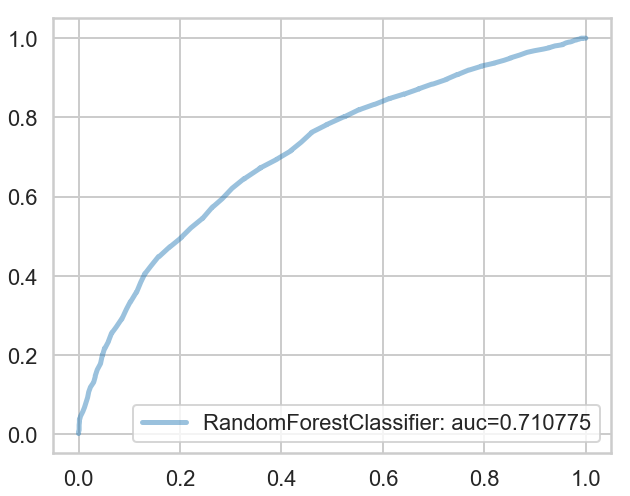

In [723]:
# Array of predictions
predictions_w2v = pd.Series(forest.predict_proba(xdat_test)[:,1])

# Get data for metrics
fpr, tpr, thresholds = roc_curve(ydat_test, predictions_w2v)
auc_score = auc(fpr, tpr)

plt.figure(figsize=(10,8))
labels = '%s: auc=%f' % ('RandomForestClassifier', auc_score)
plt.plot(fpr, tpr, line_for, linewidth=5, label=labels, alpha=0.45)
plt.legend(loc='lower right')
plt.show()


In [724]:
# Dictionary of classifiers key=name, value=(line format, classifier)
class_map2 = {
    'LogisticRegression': ('-', LogisticRegression()),
    #'Multinomial NB': ('--', MultinomialNB()),
    'Decision Tree': ('.-', DecisionTreeClassifier()),
    'Random Forest': (':', RandomForestClassifier()),
    'SVM' : ('-', SGDClassifier(loss='log', penalty='l2',
                                 alpha=1e-3, random_state=42,
                                 max_iter=5, tol=None))
}

Accuracy on training: 0.9881564450973191 with using Random Forest
Accuracy on testing: 0.6146926536731634 with using Random Forest
------------------------
Accuracy on training: 0.9980719794344473 with using Decision Tree
Accuracy on testing: 0.5870636110516171 with using Decision Tree
------------------------
Accuracy on training: 0.6848145427836945 with using LogisticRegression
Accuracy on testing: 0.6860141357892482 with using LogisticRegression
------------------------
Accuracy on training: 0.6497429305912596 with using SVM
Accuracy on testing: 0.6564574855429428 with using SVM
------------------------


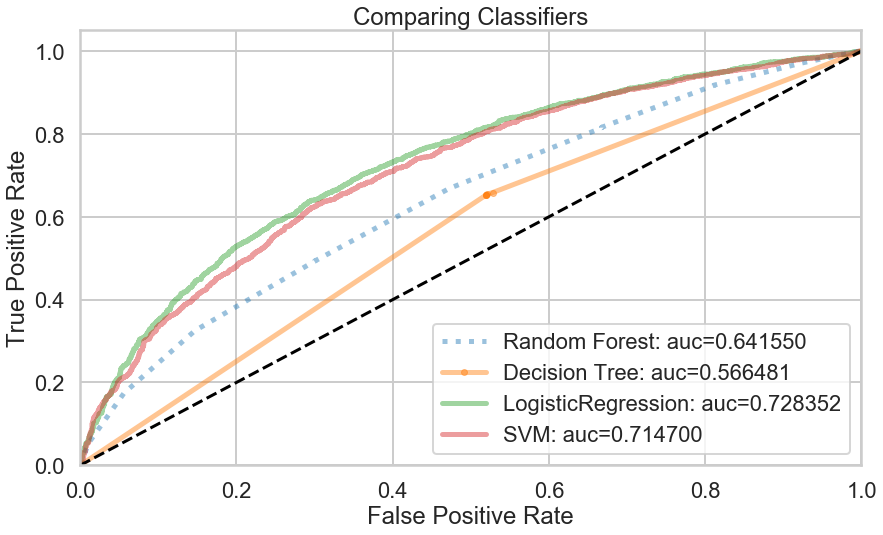

In [731]:
# Step 4: Call metrics, apply models and evaluate models
plt.figure(figsize=(14, 8))
for name, (line_for, model) in class_map2.items():
    model.fit(xdat_train, ydat_train)

    # Array of predictions
    preds = model.predict_proba(xdat_test)
    prediction = pd.Series(preds[:, 1])

    # Get data for metrics
    fpr, tpr, thresholds = roc_curve(ydat_test, prediction)
    auc_score = auc(fpr, tpr)
    labels = '%s: auc=%f' % (name, auc_score)
    plt.plot(fpr, tpr, line_for, linewidth=5, label=labels, alpha=0.45)

    # Print Scores
    print('Accuracy on training: {} with using {}'.format(
        model.score(xdat_train, ydat_train), name))
    print('Accuracy on testing: {} with using {}'.format(
        model.score(xdat_test, ydat_test), name))
    print('------------------------')

plt.legend(loc='lower right')
plt.title('Comparing Classifiers')
plt.plot([0, 1], [0, 1], 'k--')  # x=y line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('Word2Vec.png')
plt.show()

# Summary

[Summary]()